In [1]:
!nvidia-smi

Tue Apr 30 11:48:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# install autodistill
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

In [3]:
# install roboflow for good measure
!pip install roboflow

In [4]:
# easier management of data, HOME constant
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
# image dataset preparation. insert your own images here
!mkdir {HOME}/images

mkdir: cannot create directory ‘/content/images’: File exists


In [6]:
# deal with videos later

In [7]:
import supervision as sv

IMAGE_DIR_PATH = f"{HOME}/images"
image_paths = sv.list_files_with_extensions(
    directory = IMAGE_DIR_PATH,
    extensions = ["png", "jpg", "jpg"]
)

print('image count:', len(image_paths))

image count: 6


In [8]:
# plot images
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

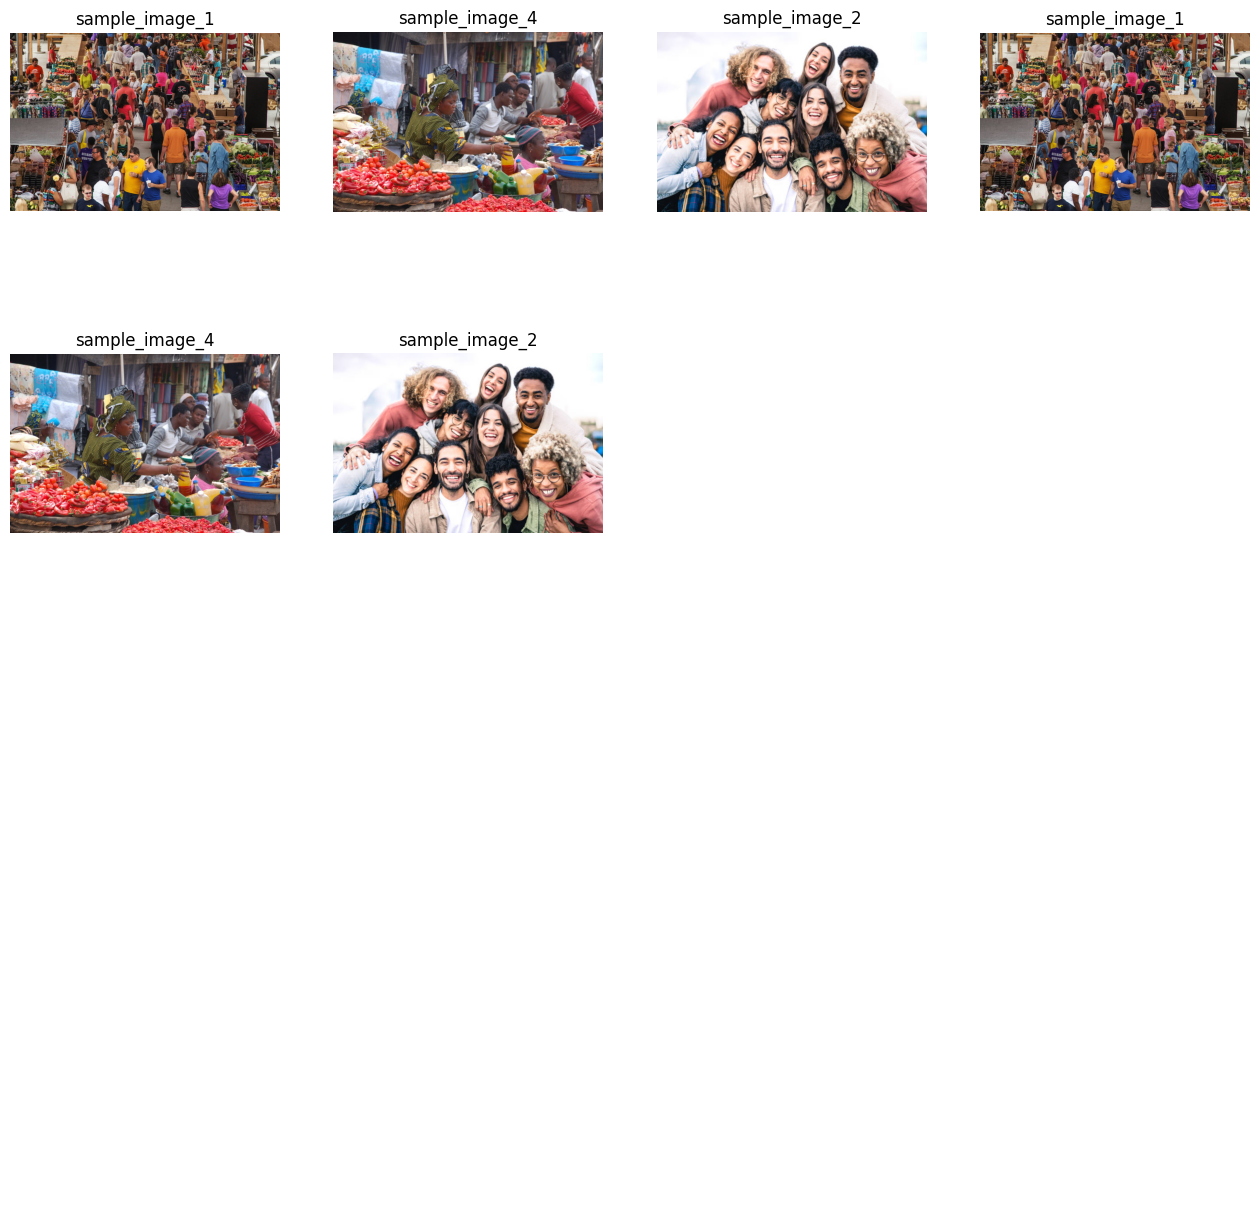

In [9]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [10]:
# autolabel dataset

from autodistill.detection import CaptionOntology

ontology = CaptionOntology({
    "person": "person"
})

In [11]:
# initiate base label and autolabel
DATASET_DIR_PATH = f"{HOME}/dataset"

In [12]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
Labeling /content/images/sample_image_1.jpg:   0%|          | 0/3 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Label

Labeled dataset created - ready for distillation.


In [13]:
# display dataset sample
ANN_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [14]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANN_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

2

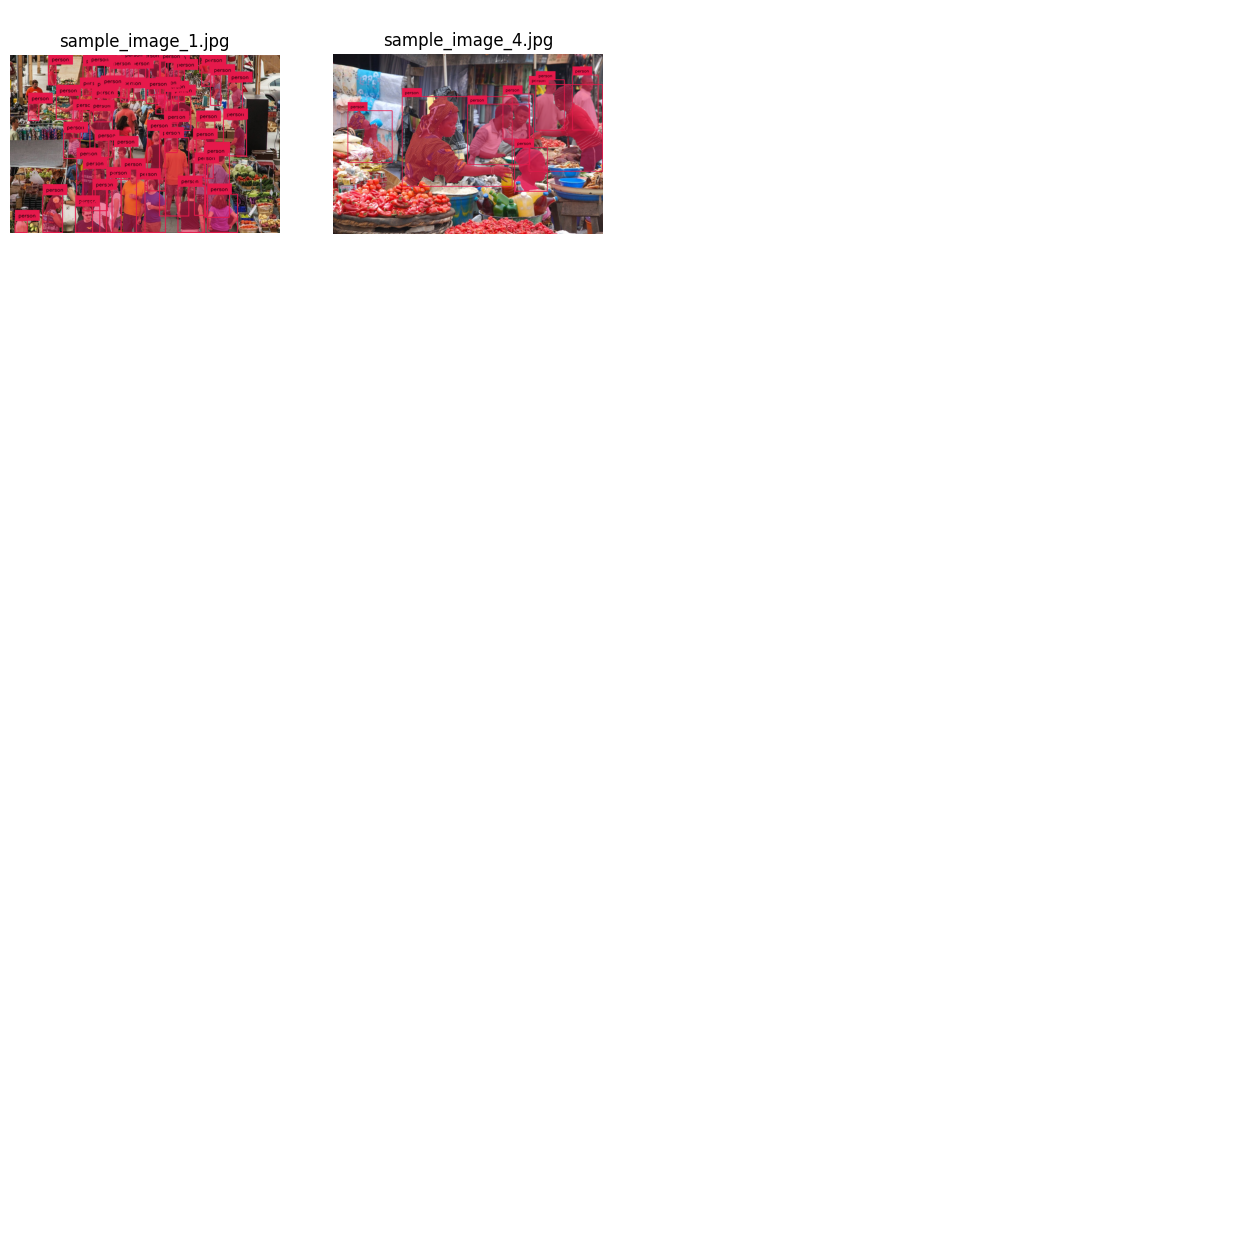

In [16]:
image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [17]:
# target model
%cd {HOME}

/content


In [18]:
from autodistill_yolov8 import YOLOv8

In [19]:
target_model = YOLOv8("yolov8l.pt")
target_model.train(DATA_YAML_PATH, epochs=100)

New https://pypi.org/project/ultralytics/8.2.5 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, 

/content


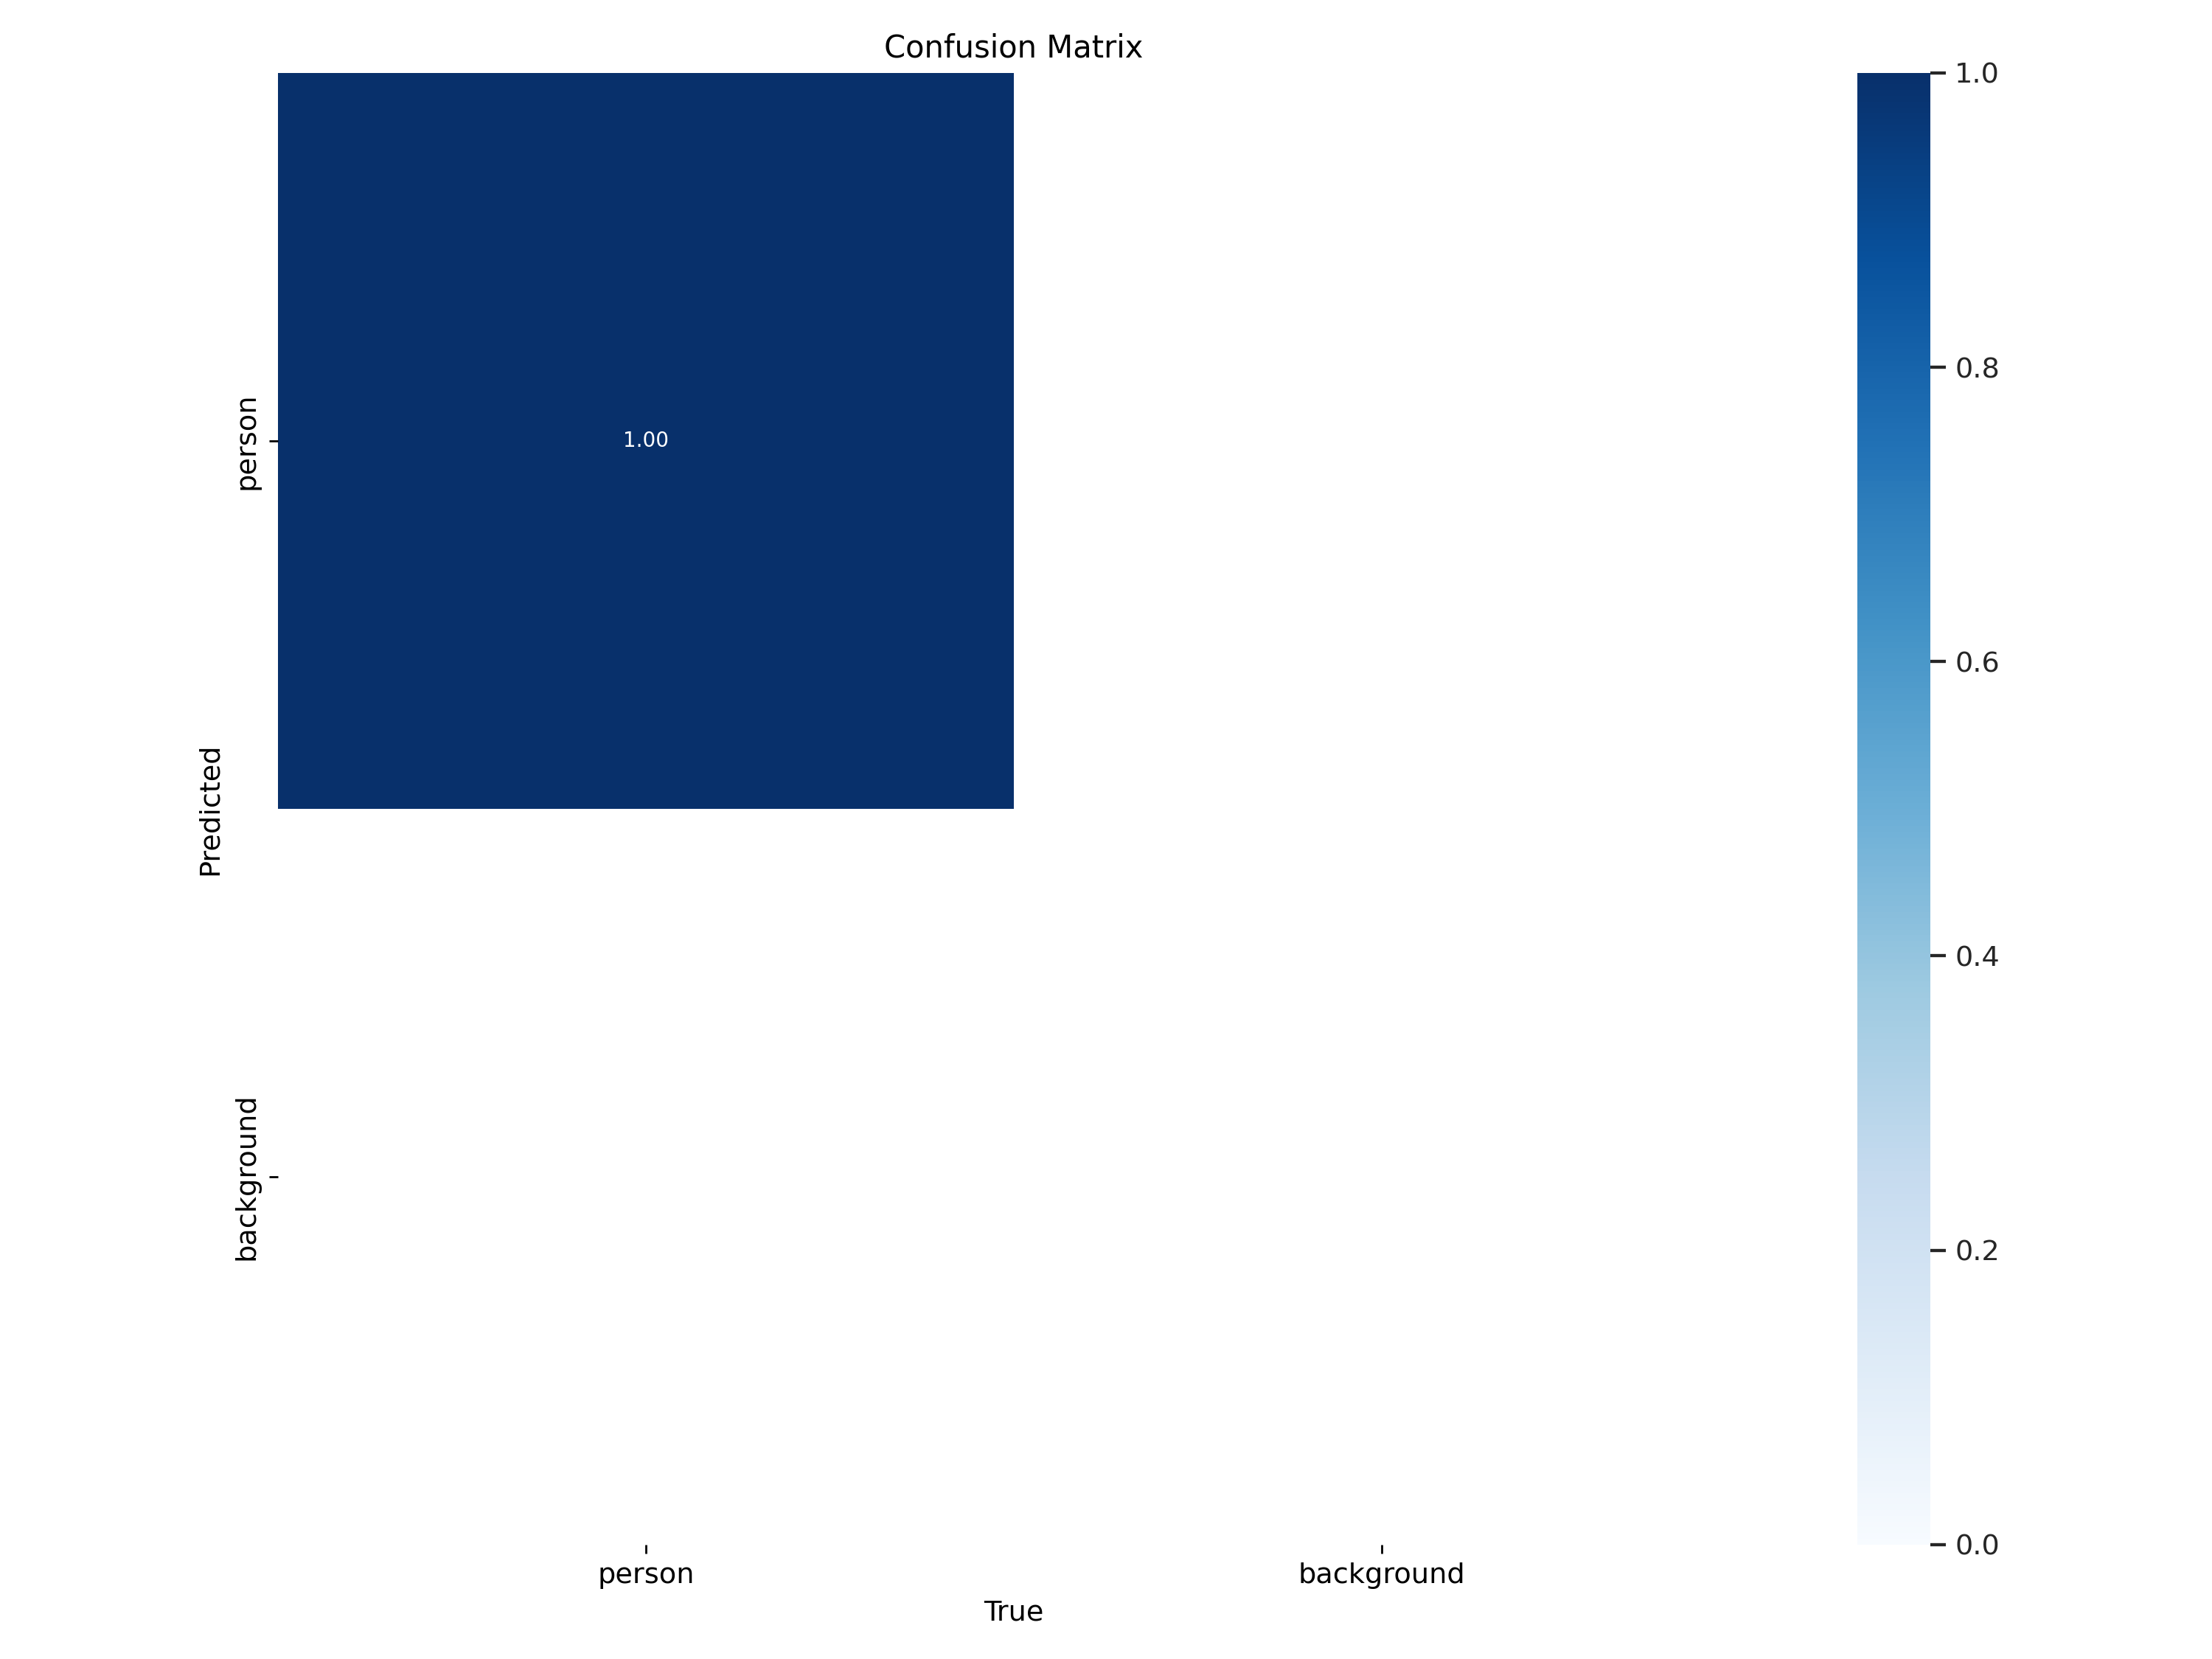

In [21]:
# evaluation:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


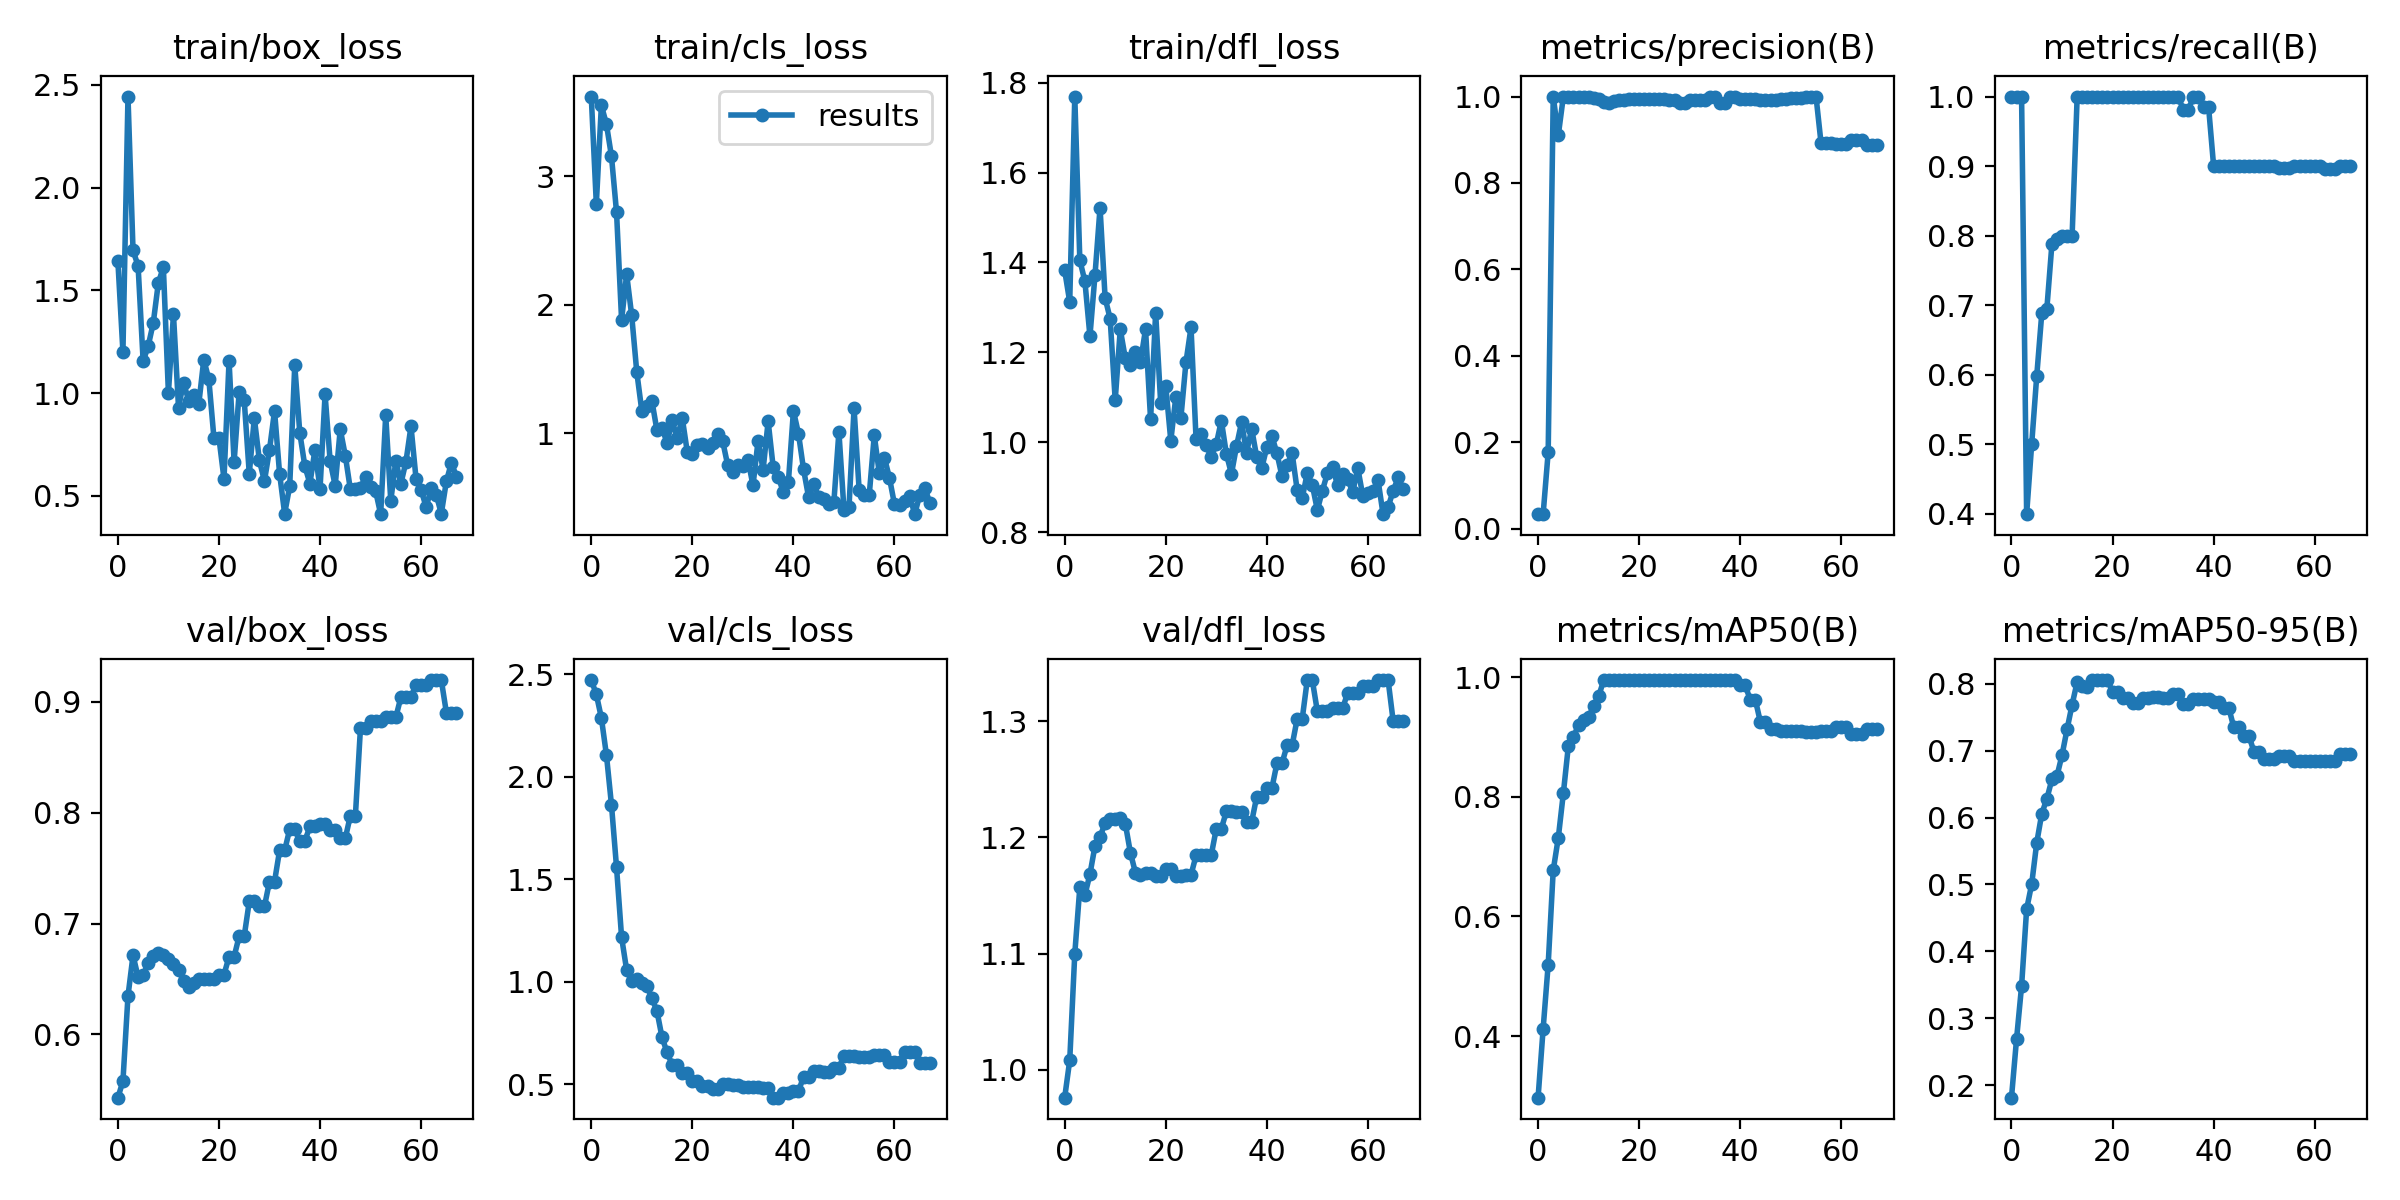

In [22]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


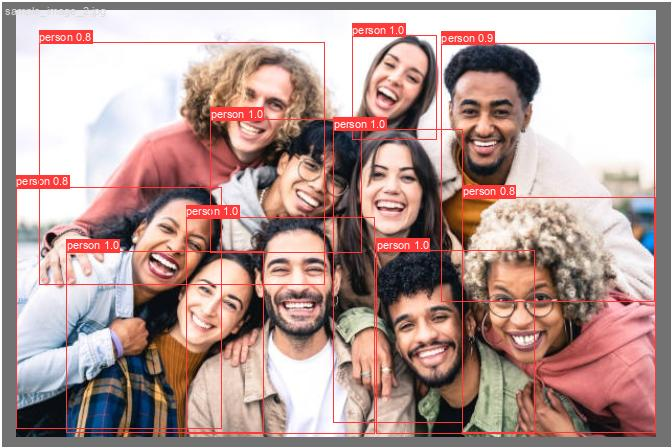

In [23]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [24]:
# inference on video
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [25]:
INPUT_VIDEO_PATH = "/content/people_video.mp4"
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [26]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 364, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 107, in __init__
    self._load(model, task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 156, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 417, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 357, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 998, in load
    with _open_file_like(f,